# MadMiner tutorial 2: SALLY, Fisher information, and ensemble methods

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In the first tutorial you saw how to set up a process with MadMiner, generate events and turn them into training samples, and construct likelihood ratio estimators from them. Here we introduce some alternative steps which will lead us to an estimator for the score at a reference point (SALLY) and the expected Fisher information. Along the way, we'll introduce some powerful ensemble methods.

If you're not familiar with SALLY, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
or, for more details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). For the information geometry part, see the original publication ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261) or a more detailed, pedagogical introduction in Chapter 4 of ["New Ideas for Effective Higgs Measurements"](https://inspirehep.net/record/1624219).

## 0. Preparations

Make sure you've run the first tutorial before executing this notebook!

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge
from madminer.plotting import plot_fisher_information_contours_2d
from madminer.fisherinformation import FisherInformation


Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [2]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2'

## 1. to 5.: see tutorial 1.

We assume that you have run steps 1 through 5 of the first tutorial, and thus have a MadMiner file with observables and event weights ready to go!

## 6. Make (unweighted) training and test samples with augmented data

Again, the next step is handled by the MadMiner class `SampleAugmenter`.

In [3]:
sa = SampleAugmenter('data/madminer_example_shuffled.h5', debug=False)

20:49  
20:49  ------------------------------------------------------------
20:49  |                                                          |
20:49  |  MadMiner v2018.10.26                                    |
20:49  |                                                          |
20:49  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
20:49  |                                                          |
20:49  ------------------------------------------------------------
20:49  
20:49  Loading data from data/madminer_example_shuffled.h5
20:49  Found 2 parameters:
20:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
20:49     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 10.0))
20:49  Found 6 benchmarks:
20:49     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
20:49     w: CWL2 = 10.00, CPWL2 = 0.00e+00
20:49     morphing_basis_vector_2: CWL2 = 7.63, CPWL2 = -8.69e+00
20:49     morphing_basis_vector_3: CWL2 = -8.59e+00, CPWL2 = -8.

The relevant `SampleAugmenter` function for local score estimators is `extract_samples_train_local()`. As before, for the argument `theta` you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`.

In [4]:
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train0'
)

20:49  Extracting training sample for local score regression. Sampling and score evaluation according to ('benchmark', 'sm')
20:49  Effective number of samples: 4754.043223892348


## 7a. Train a neural network to estimate the score

It's now time to build a neural network. Only this time, instead of the likelihood ratio itself, we will estimate the gradient of the log likelihood with respect to the theory parameters -- the score. To be precise, the output of the neural network is an estimate of the score at some reference parameter point, for instance the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

Again, the central object for this is the `madminer.ml.MLForge` class:

In [5]:
forge = MLForge(debug=False)

In [6]:
forge.train(
    method='sally',
    x_filename='data/samples/x_train0.npy',
    t_xz0_filename='data/samples/t_xz_train0.npy',
    n_epochs=10,
    batch_size=256,
    validation_split=None
)

forge.save('models/sally')

20:49  Starting training
20:49    Method:                 sally
20:49    Training data: x at data/samples/x_train0.npy
20:49                   t_xz (theta0) at  data/samples/t_xz_train0.npy
20:49    Features:               all
20:49    Method:                 sally
20:49    Hidden layers:          (100, 100, 100)
20:49    Activation function:    tanh
20:49    Batch size:             256
20:49    Epochs:                 10
20:49    Learning rate:          0.002 initially, decaying to 0.0001
20:49    Validation split:       None
20:49    Early stopping:         True
20:49  Loading training data
20:49  Found 100000 samples with 2 parameters and 2 observables
20:49  Creating model for method sally
20:49  Training model
20:49    Epoch 1: train loss 0.02 ([0.02462944])
20:49    Epoch 2: train loss 0.02 ([0.0220947])
20:50    Epoch 3: train loss 0.02 ([0.02199382])
20:50    Epoch 4: train loss 0.02 ([0.0218471])
20:50    Epoch 5: train loss 0.02 ([0.02181528])
20:51    Epoch 6: train loss 0.0

Let's evaluate the SM score on the test data

In [7]:
forge.load('models/sally')

t_hat = forge.evaluate(
    x_filename='data/samples/x_test.npy'
)

20:52  Loading settings from models/sally_settings.json
20:52    Found method sally, 2 observables, 2 parameters, (100, 100, 100) hidden layers, tanh activation function, features None
20:52  Loading state dictionary from models/sally_state_dict.pt
20:52  Loading evaluation data
20:52  Starting score evaluation


Let's have a look at the estimated score and how it is related to the observables:

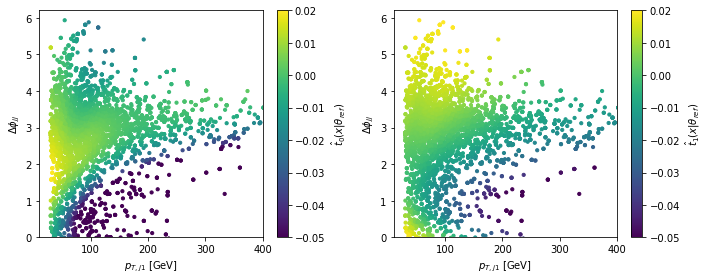

In [8]:
x = np.load('data/samples/x_test.npy')
skip=10

fig = plt.figure(figsize=(10,4))

for i in range(2):
    
    ax = plt.subplot(1,2,i+1)

    sc = plt.scatter(x[::skip,0], x[::skip,1], c=t_hat[::skip,i], s=10., cmap='viridis', vmin=-0.05, vmax=0.02)
    cbar = plt.colorbar(sc)

    cbar.set_label(r'$\hat{t}_' + str(i) + r'(x | \theta_{ref})$')
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    plt.xlim(10.,400.)
    plt.ylim(0.,6.2)
    
plt.tight_layout()
plt.show()


In addition, we can use SALLY estimators to estimate the expected Fisher information.

In [9]:
fisher = FisherInformation('data/madminer_example_shuffled.h5', debug=False)

20:52  Loading data from data/madminer_example_shuffled.h5
20:52  Found 2 parameters:
20:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
20:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 10.0))
20:52  Found 6 benchmarks:
20:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
20:52     w: CWL2 = 10.00, CPWL2 = 0.00e+00
20:52     morphing_basis_vector_2: CWL2 = 7.63, CPWL2 = -8.69e+00
20:52     morphing_basis_vector_3: CWL2 = -8.59e+00, CPWL2 = -8.65e+00
20:52     morphing_basis_vector_4: CWL2 = -5.88e+00, CPWL2 = 5.33
20:52     morphing_basis_vector_5: CWL2 = 2.84, CPWL2 = 8.99
20:52  Found 2 observables: pt_j1, delta_phi_jj
20:52  Found 101221 events
20:52  Found morphing setup with 6 components


In [10]:
fisher_information = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/sally',
    unweighted_x_sample_file='data/samples/x_test.npy',
    luminosity=300000.
)

print('Kinematic Fisher information after 300 ifb:\n{}'.format(fisher_information))

20:52  Loading settings from models/sally_settings.json
20:52    Found method sally, 2 observables, 2 parameters, (100, 100, 100) hidden layers, tanh activation function, features None
20:52  Loading state dictionary from models/sally_state_dict.pt
20:52  Loading evaluation data
20:52  Starting score evaluation
20:52  Expected score (should be close to zero): [-0.00569082  0.00343044]


Kinematic Fisher information after 300 ifb:
[[6.42465051 0.76442561]
 [0.76442561 0.92257369]]


We can visualize the Fisher information with contours:

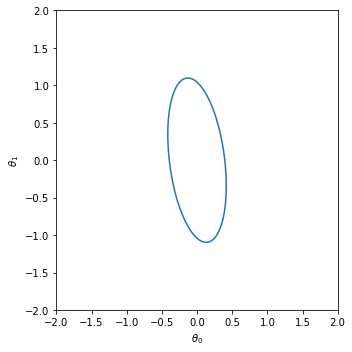

In [15]:
_ = plot_fisher_information_contours_2d(
    [fisher_information],
    xrange=(-2.,2.),
    yrange=(-2.,2.)
)

## 7b. Ensemble methods

Instead of using a single neural network to estimate the likelihood ratio, score, or Fisher information, we can use an ensemble of such estimators. That provides us with a more reliable mean prediction as well as a measure of the uncertainty. The class `madminer.ml.EnsembleForge` automates this process. Currently, it only supports SALLY estimators:

In [16]:
ensemble = EnsembleForge(estimators=5)

The `EnsembleForge` object has very similar functions as `MLForge`. In particular, we can train all estimators simultaneously with `train_all()` and save the ensemble to files:

In [17]:
ensemble.train_all(
    method='sally',
    x_filename='data/samples/x_train0.npy',
    t_xz0_filename='data/samples/t_xz_train0.npy',
    n_epochs=10,
    batch_size=256,
    validation_split=None
)

ensemble.save('models/sally_ensemble')

20:54  Training 5 estimators in ensemble
20:54  Training estimator 1 / 5 in ensemble
20:54  Starting training
20:54    Method:                 sally
20:54    Training data: x at data/samples/x_train0.npy
20:54                   t_xz (theta0) at  data/samples/t_xz_train0.npy
20:54    Features:               all
20:54    Method:                 sally
20:54    Hidden layers:          (100, 100, 100)
20:54    Activation function:    tanh
20:54    Batch size:             256
20:54    Epochs:                 10
20:54    Learning rate:          0.002 initially, decaying to 0.0001
20:54    Validation split:       None
20:54    Early stopping:         True
20:54  Loading training data
20:54  Found 100000 samples with 2 parameters and 2 observables
20:54  Creating model for method sally
20:54  Training model
20:54    Epoch 1: train loss 0.02 ([0.02386439])
20:55    Epoch 2: train loss 0.02 ([0.0220052])
20:55    Epoch 3: train loss 0.02 ([0.02189462])
20:55    Epoch 4: train loss 0.02 ([0.021818

Any evaluation of this ensemble will provide us with mean and variance of the predictions. Let's try that for the Fisher information:

In [18]:
fisher = FisherInformation('data/madminer_example_shuffled.h5', debug=False)

fisher_information_mean, fisher_information_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/sally_ensemble',
    unweighted_x_sample_file='data/samples/x_test.npy',
    luminosity=300000.
)

21:06  Loading data from data/madminer_example_shuffled.h5
21:06  Found 2 parameters:
21:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
21:06     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 10.0))
21:06  Found 6 benchmarks:
21:06     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
21:06     w: CWL2 = 10.00, CPWL2 = 0.00e+00
21:06     morphing_basis_vector_2: CWL2 = 7.63, CPWL2 = -8.69e+00
21:06     morphing_basis_vector_3: CWL2 = -8.59e+00, CPWL2 = -8.65e+00
21:06     morphing_basis_vector_4: CWL2 = -5.88e+00, CPWL2 = 5.33
21:06     morphing_basis_vector_5: CWL2 = 2.84, CPWL2 = 8.99
21:06  Found 2 observables: pt_j1, delta_phi_jj
21:06  Found 101221 events
21:06  Found morphing setup with 6 components
21:07  Loading ensemble setup from models/sally_ensemble/ensemble.json
21:07    Found ensemble with 5 estimators and expectations None
21:07  Loading settings from models/sally_ensemble/estimator_0_settings.json
21:07    Found method sal

The covariance can be propagated to the Fisher distance contour plot easily:

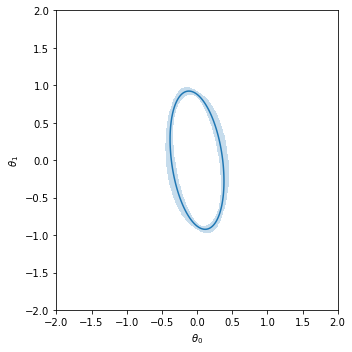

In [19]:
_ = plot_fisher_information_contours_2d(
    [fisher_information_mean],
    [fisher_information_covariance],
    xrange=(-2.,2.),
    yrange=(-2.,2.)
)

Confused? If you have questions, please have a look at the papers, the module documentation, or drop us an email!